In [203]:
import obspy
from obspy.taup import TauPyModel

from multiprocessing import Pool
from obspy import read,UTCDateTime,Trace,read_inventory,read_events
from obspy.io.sac.sactrace import SACTrace
from obspy.imaging.beachball import beachball,beach
from obspy.clients.fdsn import Client
from obspy.signal.trigger import recursive_sta_lta

import os
from glob import glob
import numpy as np
from collections import defaultdict
import pandas as pd
from scipy import signal
import subprocess
from sklearn import preprocessing
import geopy.distance


#para plotar as figuras
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

import matplotlib.cm as cm
from matplotlib.dates import YearLocator, MonthLocator, DayLocator, HourLocator, MinuteLocator, SecondLocator, DateFormatter
from matplotlib.ticker import MultipleLocator, FormatStrFormatter,FixedLocator,StrMethodFormatter
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

from datetime import datetime,timedelta,date
from tqdm import tqdm

from shapely.geometry.polygon import LinearRing
from matplotlib.patches import Rectangle
import geopandas as gpd

import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
import requests
import csv
import xml.etree.ElementTree as ET
import ast

# INPUT DATA

In [204]:
EVENT_GLIDER = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/LFI/EVENTS_GLIDERS/'
EVENT_RSBR = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/DATA_EVENTS/'
QUAKEXML_FOLDER = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/EVENTS/'
FOLDER_OUTPUT = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/LFI/'
TABLE_EVENTS_RECORDED = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/LFI/FIGURAS/STATISTICS/table_events_selected.csv'
MODEL_CAKE = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/EARTH_MODEL_AREA/model_ak135_SOFAR.nd'


In [205]:
def energy_ratio(a, nsta):
    r"""
    Energy ratio detector.

    Energy ratio defined as

    .. math::
        \text{er}(i) = \frac{\sum_{j=i}^{i+L}{a_j^2}}{\sum_{j=i-L}^{i}{a_j^2}}

    where :math:`L` is ``nsta``.

    :type a: NumPy :class:`~numpy.ndarray`
    :param a: Seismic Trace
    :type nsta: int
    :param nsta: Length of the energy ratio window in samples. It's the same
                 length as ``nsta`` in the classical STA/LTA methods.
    :rtype: NumPy :class:`~numpy.ndarray`
    :return: Energy Ratio

    .. seealso:: [Han2009]_
    """
    if nsta > len(a) // 2:
        # Half forward, half backward -> empty medium
        msg = (
            f'nsta ({nsta}) must not be larger than half the length of the '
            f'data ({len(a)} samples).')
        raise ValueError(msg)
    if nsta <= 0:
        # If nsta is zero, the sum is undefined
        msg = f'nsta ({nsta}) must not be equal to or less than zero.'
        raise ValueError(msg)
    sig_power = np.r_[0, np.cumsum(a ** 2, dtype=np.float64)]
    energy_diff = sig_power[nsta:] - sig_power[:len(sig_power) - nsta]
    er = np.zeros(len(a), dtype=np.float64)
    np.divide(energy_diff[nsta:], energy_diff[:len(energy_diff) - nsta],
              where=energy_diff[:len(energy_diff) - nsta] != 0,
              out=er[nsta:len(er) - nsta + 1])
    return er

def modified_energy_ratio(a, nsta, power=3):
    r"""
    Modified energy ratio detector.

    Improvement of the :func:`energy_ratio` that accounts for the signal
    itself:

    .. math::
        \text{mer}(i) = (\text{er}(i) * |a(i)|)^3

    where :math:`text{er}(i)` is the :func:`energy_ratio`.

    :type a: NumPy :class:`~numpy.ndarray`
    :param a: Seismic Trace
    :type nsta: int
    :param nsta: Length of energy ratio window in samples. It's the same length
                 as ``nsta`` in the classical STA/LTA methods.
    :type power: int
    :param power: The power exponent in the equation above. Default: 3
    :rtype: NumPy :class:`~numpy.ndarray`
    :return: Modified Energy Ratio
    """
    er = energy_ratio(a, nsta=nsta)
    mer = np.power(er * np.abs(a), power, out=er)
    return mer

In [206]:
files_lfi_rsbr = glob('*.2020.*')

In [207]:
glider = []
rsbr = []

for i in files_lfi_rsbr:
    if i[:2] == 'LF' or i[:2] == 'GL':
        glider.append(i)
    else:
        rsbr.append(i)

In [208]:
cat2 = obspy.read_events('*.xml')


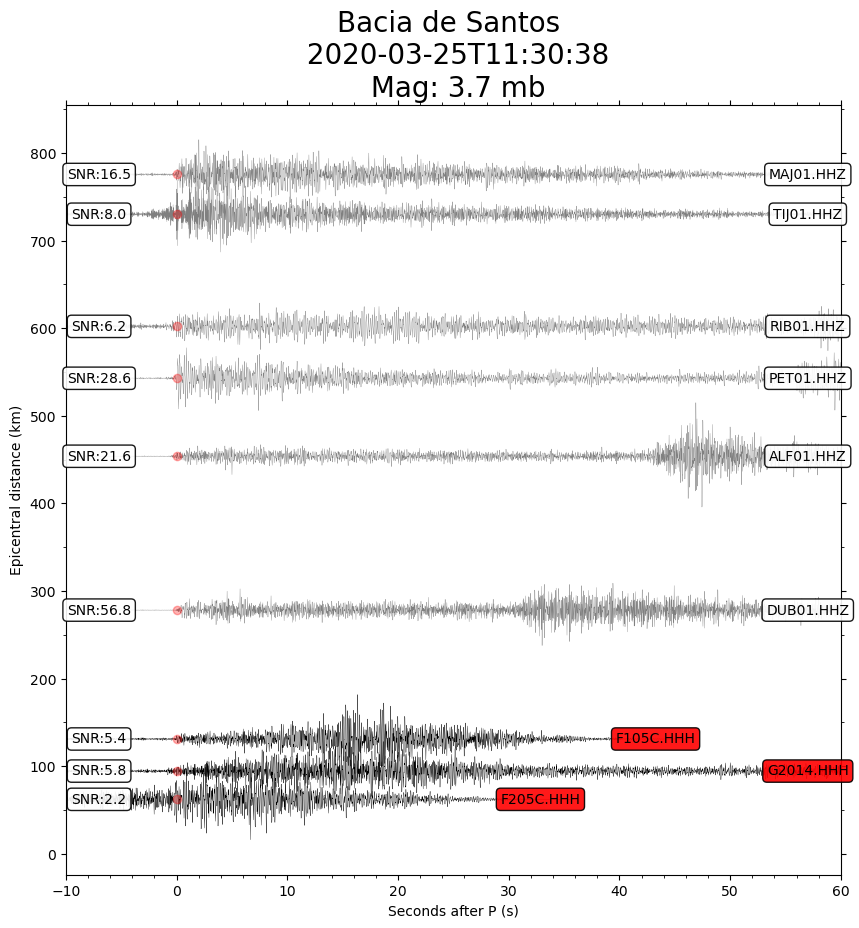

In [249]:
# set up the plot and create a GeoAxes:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()

time_ev = cat[0].origins[-1].time

freqmin = 5
freqmax = 20


sta = 5
len_event = 60

# ============= #
# RSBR STATIONS
# ============= #
for st_file in rsbr:
    st_plot = obspy.read(st_file)[0]
                
    gcarc = st_plot.stats.sac.dist
    df = st_plot.stats.sampling_rate
        
    st_plot.filter('bandpass',freqmin=freqmin,freqmax=freqmax, corners=4, zerophase=False)
    st_plot.taper(max_percentage=0.3, type='cosine')      
    st_plot.detrend('linear')
    st_plot.detrend('demean')

    cft = modified_energy_ratio(a=st_plot.data,nsta=int(sta * df), power=3)
    st_plot.trim(st_plot.times('utcdatetime')[cft.argmax()]-10,st_plot.times('utcdatetime')[cft.argmax()]+len_event)
        
    ax.plot(st_plot.times()[1000]-10,gcarc,c='r',marker='o',alpha=0.3,label='P arrival',zorder=10)                   
    ax.plot(st_plot.times()-10,gcarc+preprocessing.normalize([st_plot.data])[0]*500,c='grey',ls='-',lw=0.25)
    ax.text(x=st_plot.times()[-300]-10,y=gcarc,s=st_plot.stats.station+'.'+st_plot.stats.channel,ha="center",va="center",bbox=dict(boxstyle="round",ec='k',fc='w',alpha=0.9))

    # ----------------------------------------------------------------------------------------------------------
    # SNR P-wave
    # ----------------------------------------------------------------------------------------------------------
                
    # --------------------------------------------------------------------
    # Retrieving the P-wave normalized amplitude between -x and +x seconds

    amp_P = st_plot.data[1000:1500]
    
    # -------------------------------------------------------------------
    # Retrieving the noise normalized amplitude between -x and +x seconds

    noise_amp = st_plot.data[400:900]
        
    # ---------------
    # Evaluating: SNR
                                            
    powS = np.mean(np.abs(amp_P))
    powN = np.mean(np.abs(noise_amp))
    
    snr = powS/powN
    snr = round(snr,1)

    ax.text(x=st_plot.times()[300]-10,y=gcarc,s='SNR:'+str(snr),ha="center",va="center",bbox=dict(boxstyle="round",ec='k',fc='w',alpha=0.9))


for st_file_glider in glider:
    st_plot_glider = obspy.read(st_file_glider)[0]
        
    gcarc_glider = st_plot_glider.stats.sac.dist
    df = st_plot_glider.stats.sampling_rate

            
    st_plot_glider.filter('bandpass',freqmin=freqmin,freqmax=freqmax, corners=4, zerophase=False)
    st_plot_glider.taper(max_percentage=0.3, type='cosine')      
    st_plot_glider.detrend('linear')
    st_plot_glider.detrend('demean')

    cft_glider = modified_energy_ratio(a=st_plot_glider.data,nsta=int(sta * df), power=3)
    st_plot_glider.trim(st_plot_glider.times('utcdatetime')[cft_glider.argmax()]-10,st_plot_glider.times('utcdatetime')[cft_glider.argmax()]+len_event)
        
    ax.plot(st_plot_glider.times()[1000]-10,gcarc_glider,c='r',marker='o',alpha=0.3,label='P arrival',zorder=10)                   
    ax.plot(st_plot_glider.times()-10,gcarc_glider+preprocessing.normalize([st_plot_glider.data])[0]*500,c='k',ls='-',lw=0.25)
    ax.text(x=st_plot_glider.times()[-300]-10,y=gcarc_glider,s=st_plot_glider.stats.station+'.'+st_plot_glider.stats.channel,ha="center",va="center",bbox=dict(boxstyle="round",ec='k',fc='r',alpha=0.9))
    
    # ----------------------------------------------------------------------------------------------------------
    # SNR P-wave
    # ----------------------------------------------------------------------------------------------------------
                
    # --------------------------------------------------------------------
    # Retrieving the P-wave normalized amplitude between -x and +x seconds

    amp_P = st_plot_glider.data[1000:1500]
    
    # -------------------------------------------------------------------
    # Retrieving the noise normalized amplitude between -x and +x seconds

    noise_amp = st_plot_glider.data[400:900]
        
    # ---------------
    # Evaluating: SNR
                                            
    powS = np.mean(np.abs(amp_P))
    powN = np.mean(np.abs(noise_amp))
    
    snr = powS/powN
    snr = round(snr,1)

    ax.text(x=st_plot.times()[300]-10,y=gcarc_glider,s='SNR:'+str(snr),ha="center",va="center",bbox=dict(boxstyle="round",ec='k',fc='w',alpha=0.9))


#ax.set_ylabel('Epicentral distance ($^\circ$)')
ax.set_ylabel('Epicentral distance (km)')
#ax.set_ylim(0,8)
ax.set_xlim(-10,len_event)
ax.set_xlabel('Seconds after P (s)')
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.yaxis.set_major_locator(MultipleLocator(100))
ax.yaxis.set_minor_locator(MultipleLocator(50))
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

# ----------------------------------------------------------------------------------------------------------
# focal mechanisms
# ----------------------------------------------------------------------------------------------------------

ev_lat = st_plot_glider.stats.sac.evla
ev_long = st_plot_glider.stats.sac.evlo
ev_depth = st_plot_glider.stats.sac.evdp
magnitude = st_plot_glider.stats.sac.mag
magnitude_type = 'mw'

# ----------------------------------------------------------------------------------------------------------
# Title
ax.set_title('Bacia de Santos \n '+cat2[0].origins[0].time.strftime('%Y-%m-%dT%H:%M:%S')+'\n Mag: 3.7 mb',fontsize=20)

# ----------------------------------------------------------------------------------------------------------
# Saving figure
fig.savefig('event_LFI_'+time_ev.strftime('%Y-%m-%dT%H:%M:%S')+'_'+cat2[0].event_descriptions[0].text+'.png',pad_inches=0.0,dpi=200)
#plt.close()

In [244]:
cat2[0].event_descriptions[0].text


'South Atlantic Ocean'

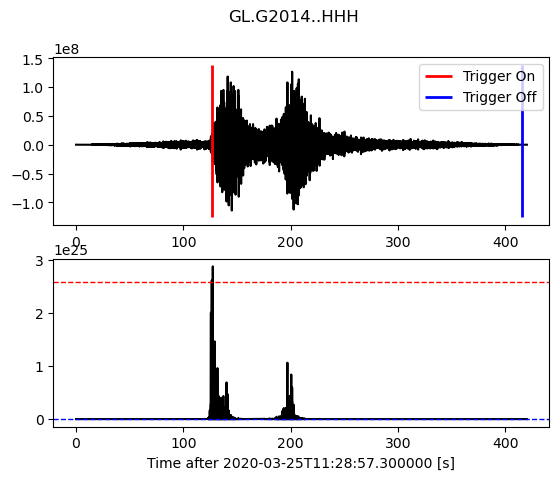

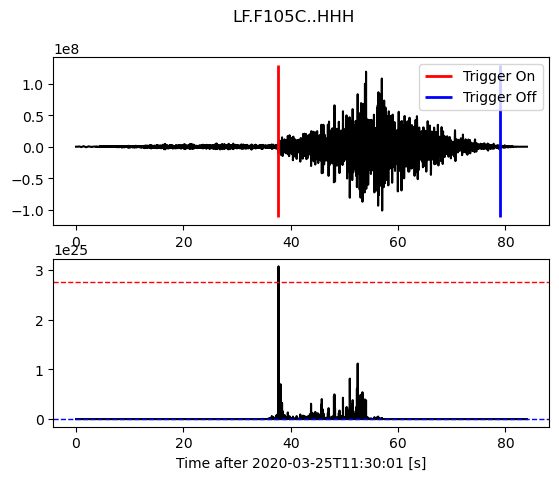

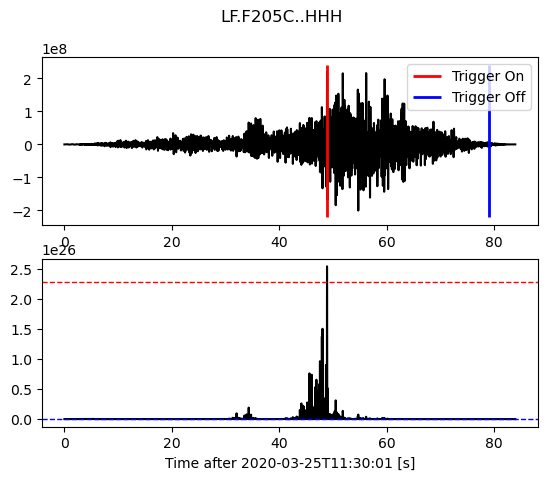

In [247]:
from obspy.signal.trigger import plot_trigger

for i in sorted(glider):
    a = obspy.read(i)
    a.filter('bandpass',freqmin=freqmin,freqmax=freqmax, corners=4, zerophase=False)
    a.taper(max_percentage=0.3, type='cosine')      
    a.detrend('linear')
    a.detrend('demean')
    trace = a[0]    
    df = trace.stats.sampling_rate

    try:
        cft = modified_energy_ratio(a=trace.data,nsta=int(5 * df), power=3)
        fig, axes = plot_trigger(trace, cft, cft.max()*0.9, 0.1)
        
        axes[0].text(x=trace.times()[cft.argmax()],y=trace.data[cft.argmax()],s='P',ha="center",va="center",bbox=dict(boxstyle="round",ec='k',fc='w',alpha=0.5))
        axes[1].set_yscale('log')
        axes[1].set_ylim(ymin=0.01)
    except:
        pass
     

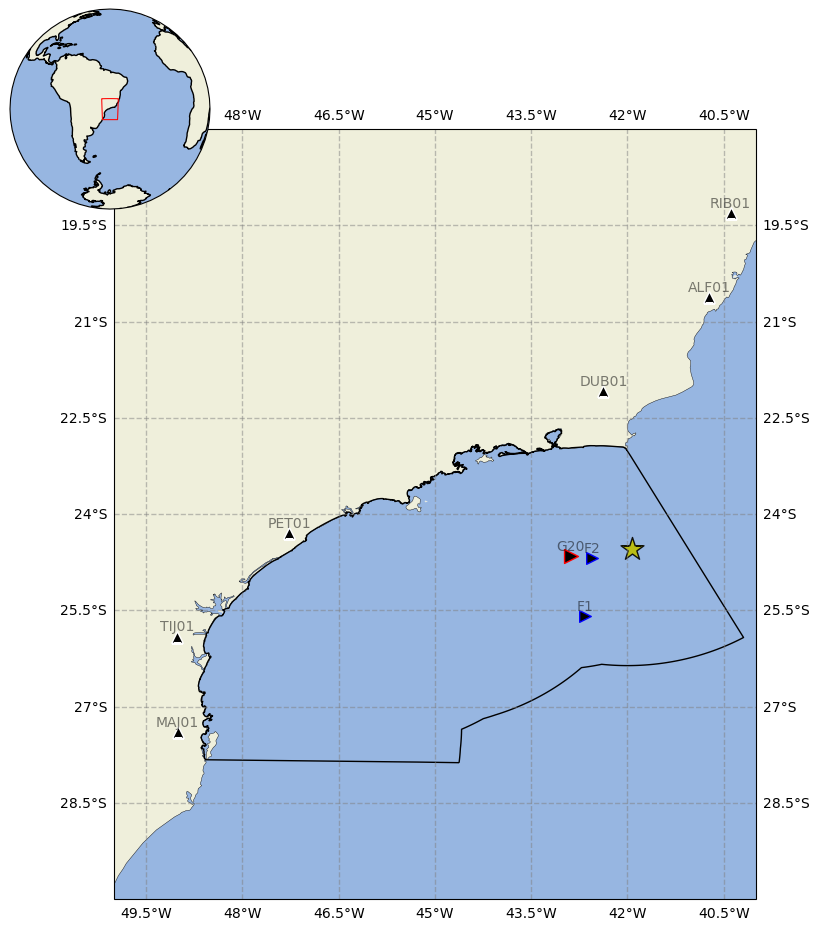

In [212]:
# Create a figure
# set up the plot and create a GeoAxes:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(1, 1,figsize=(20,10), subplot_kw=dict(projection=proj))

# ----------------------------------------------------------------------------------------------------------
# Limit the extent of the map to a small longitude/latitude range.
latmin=-30
latmax=-18
lonmin=-50
lonmax=-40

ax.set_extent([lonmin,lonmax, latmin, latmax], crs=ccrs.Geodetic())

# ----------------------------------------------------------------------------------------------------------
# Ploting lat/lon values

# Use the cartopy interface to create a matplotlib transform object
# for the Geodetic coordinate system. We will use this along with
# matplotlib's offset_copy function to define a coordinate system which
# translates the text by 25 pixels to the left.
geodetic_transform = ccrs.Geodetic()._as_mpl_transform(ax)
text_transform = offset_copy(geodetic_transform, units='dots', x=0,y=10)

for st_file in rsbr:
    st_plot = obspy.read(st_file,headonly=True)[0]

    stlo = st_plot.stats.sac.stlo
    stla = st_plot.stats.sac.stla
    station_name = st_plot.stats.station
                
    ax.scatter(stlo,stla,c='k',marker='^',ec='w',s=70,transform=proj)
    ax.text(stlo,stla,s=station_name, verticalalignment='center', horizontalalignment='center',alpha=0.5,transform=text_transform)


for st_file_glider in glider:
    st_plot_glider = obspy.read(st_file_glider,headonly=True)[0]

    stlo = st_plot_glider.stats.sac.stlo
    stla = st_plot_glider.stats.sac.stla
    station_name = st_plot_glider.stats.station
                
    if 'F' in station_name:
        ax.text(stlo,stla,s=station_name[:2], verticalalignment='center', horizontalalignment='center',alpha=0.5,transform=text_transform)
        ax.scatter(stlo,stla,c='k',marker='>',ec='b',s=70,transform=proj)

    else:
        ax.text(stlo,stla,s=station_name[:3], verticalalignment='center', horizontalalignment='center',alpha=0.5,transform=text_transform)
        ax.scatter(stlo,stla,c='k',marker='>',ec='r',s=100,transform=proj)


ax.scatter(cat2[0].origins[-1].longitude,cat2[0].origins[-1].latitude,c="y",marker='*',edgecolor='k',alpha=0.9,s=300)

# ----------------------------------------------------------------------------------------------------------
# Adding background map 
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE,linewidth=0.3)
ax.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')

# ----------------------------------------------------------------------------------------------------------
# Adding colorbar

# Carregar o shapefile usando GeoPandas
shapefile_path = "/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/SIG_dados/shapes/Bacias Sedimentares Oceanicas/AtlasMar_BaciasSedimentaresOceanicas_SE.shp"  # Substitua pelo caminho do seu shapefile
gdf = gpd.read_file(shapefile_path)

# Plotar o shapefile no mapa
gdf.plot(ax=ax, facecolor="none", edgecolor="k", linewidth=1, transform=ccrs.PlateCarree())


#####################################################
# Adding inset axes LEFT
#####################################################

# ----------------------------------------------------------------------------------------------------------
# Adding global location map
# Adding Geoaxes
ax_map = plt.axes([0.25, 0.8, 0.2, 0.2], projection=ccrs.Orthographic(central_latitude=(latmin + latmax)/2,central_longitude=(lonmin + lonmax) / 2))
ax_map.set_global()

# Adding background map 
ax_map.add_feature(cfeature.LAND)
ax_map.add_feature(cfeature.OCEAN)
ax_map.add_feature(cfeature.COASTLINE)

# Adding red rectangle position
nvert = 100
lons = np.r_[np.linspace(lonmin, lonmin, nvert),
             np.linspace(lonmin, lonmax, nvert),
             np.linspace(lonmax, lonmax, nvert)].tolist()
lats = np.r_[np.linspace(latmin, latmax, nvert),
             np.linspace(latmax, latmax, nvert),
             np.linspace(latmax, latmin, nvert)].tolist()

ring = LinearRing(list(zip(lons, lats)))
ax_map.add_geometries([ring], ccrs.PlateCarree(),
                   facecolor='none', edgecolor='red', linewidth=0.75)

fig.savefig('event_LFI_GLIDER_'+time_ev.strftime('%Y-%m-%dT%H:%M:%S')+'_'+cat2[0].event_descriptions[0].text+'_location.png',pad_inches=0.0,dpi=200)
